<a href="https://colab.research.google.com/github/824024445/Machine-learning-notes/blob/master/3%E5%88%86%E7%B1%BB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 加载数据
机器学习的初学者迟早会接触Minist这个数据集，sklearn提供很多辅助函数用于下载流行的数据集

`fetch_mldata`出错修改方式  
1. 下载文件https://github.com/amplab/datascience-sp14/raw/master/lab7/mldata/mnist-original.mat
2. 创建一个文件夹：datasets/mldata,将下载好的mnist-original.mat文件放在这个文件夹之中。
3. fetch_mldata('MNIST original', data_home="datasets")，data_home参数即为从本地导入数据的地址。

In [7]:
from sklearn.datasets import fetch_mldata

mnist = fetch_mldata('MNIST original', data_home="sample_data")
mnist

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:85: DeprecationWarning: Function fetch_mldata is deprecated; fetch_mldata was deprecated in version 0.20 and will be removed in version 0.22. Please use fetch_openml.
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:85: DeprecationWarning: Function mldata_filename is deprecated; mldata_filename was deprecated in version 0.20 and will be removed in version 0.22. Please use fetch_openml.
  warnings.warn(msg, category=DeprecationWarning)


{'COL_NAMES': ['label', 'data'],
 'DESCR': 'mldata.org dataset: mnist-original',
 'data': array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint8),
 'target': array([0., 0., 0., ..., 9., 9., 9.])}

In [3]:
X, y = mnist["data"], mnist["target"]
print(X.shape)
print(y.shape)

(70000, 784)
(70000,)


可知，有70000个样本（图片），每个样本有784个特征值。这是因为每个图片都是28乘28个像素点的图片，每个像素点的值介于0-255之间。  
可以通过Matplotlib的imshow函数展示出来

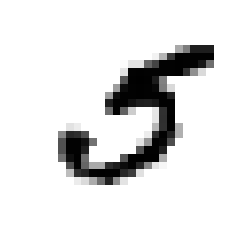

5.0

In [4]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

some_digit = X[36000]
some_digit_image = some_digit.reshape(28,28)
plt.imshow(some_digit_image, cmap = matplotlib.cm.binary, interpolation="nearest")
plt.axis("off")
plt.show()
y[36000]

# 创建数据集
> 这里要备注一下：为什么用这种切分数据集的方式呢。首先我们要知道这种方法是存在的且合理的。
- 首先我们要知道切分数据集的目的在于：评估泛化误差（就是用于预测误差）
- 其次要知道切分数据集的方法有很多种
  - 留出法：就是这种方法，直接将数据且分为两个互斥子集
  - 交叉验证法：将数据集分成k个互斥子集，然后每个子集作为测试集，其它子集的并集作为训练集进行测试然后取平均值
  - 自助法：即常用的随机取数的方法

In [0]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

In [0]:
import numpy as np
shuffle_index = np.random.permutation(60000)
X_train, y_train = X_train[shuffle_index], y_train[shuffle_index]

# 训练一个二分类器

因为数据比较好，跳过了查找关联、数据清洗阶段。直接进行模型选择和评估。

先训练一个简单的，只识别数字“9”，修改样本集

In [58]:
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)
print(y_train_5)

[False False  True ... False False  True]


## 使用决策树

In [59]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=42, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [74]:
sgd_clf.predict([some_digit]) # some_digit = X[36000]
# 这里加中括号的原因是：预测的数组X，要传入类array格式的数据，可以使numpy格式，也可以是list格式。
# 应该是一行代表一个样本。而如果直接传入some_digit格式的话，它只是一个样本，默认会把它的每一行作为一个样本，而实际上那只是一个样本中的一行而已。
# 最后预测为True，可见对于这一个样本预测的结果是正确的

array([ True])

## 评估性能

评估分类器比评估回归器更加玄学，本节会深入讲解

### 1.使用交叉验证评估性能

#### 自己简写cross_val_score函数
StratifiedKFol类:分层k折交叉验证器，主要函数为split(),可以返回所有遍历的测试集和训练集的索引

In [0]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone 

skfolds = StratifiedKFold(n_splits=3, random_state=42)
for train_index, test_index in skfolds.split(X_train, y_train_5):
  clone_clf = clone(sgd_clf)
  X_train_fold = X_train[train_index]
  y_train_fold = (y_train_5[train_index])
  X_test_fold = X_test[test_index]
  y_test_fold = (y_test_5[test_index])

  clone_clf.fit(X_train_fold, y_train_fold)
  y_pred = clone_clf.pridict(X_test_fold)
  n_correct = sum(y_pred == y_test_5)
  print(n_correct/len(y_pred))

#### 使用官方函数正式评估

In [77]:
from sklearn.model_selection import cross_val_score

cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.96595, 0.9486 , 0.95335])

虽然有96%的准确度，但是这个数据集只有10%的数据是5，所以如果有一个预测期全部预测为否也会有90%的准确度。  
**这也就是为什么精度常常不是很好地性能度量指标**

### 2.混淆矩阵（更适合分类器）
关于混淆矩阵更详细的信息见西瓜书2.3.1
大体思路是：输出类别A被分类成类别 B 的次数。举个例子，为了知道分类器将 5 误分为 3 的次数，你需要查看混淆矩阵的第五行第三列。

> ps:记住，只有当你处于项目的尾声，当你准备上线一个分类器的时候，你才应该使用测试集

- 第一步先获取预测值
- 第二步使用混淆矩阵，输入真实值和预测值

In [0]:
from sklearn.model_selection import cross_val_predict # 为每个输入数据点生成交叉验证的估计值
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [82]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_train_5, y_train_pred)

array([[53428,  1151],
       [ 1491,  3930]])

### 准确率和召回率（查准率和查全率）
是混淆矩阵的延伸，混淆矩阵中指标的比值  


In [1]:
from sklearn.metrics import precision_score, recall_score

precision_score(y_train_5, y_train_pred)

NameError: ignored

In [2]:
recall_score(y_train_5, y_train_pred)

NameError: ignored

单一准确率和召回率通常没什么用，需要结合来看。一般来说，准确率较高时，召回率较低。召回率较高时，准确率较低。
- 准曲率和召回率